# Convergence Test 
Only trust those don't change under different resolutions.

In [15]:
import numpy as np
from nozzle import Spectral, Params, Nozzle
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

In [3]:
Mm = 1.5
accelerating = False
N_range = range(51,352,50)

experiments = []
for N in tqdm(N_range):
    params = Params(Mm, accelerating=accelerating)
    spectral = Spectral(N, "symmetric", "FD")
    nozzle = Nozzle(params, spectral.x)
    v0 = nozzle.v0
    x = spectral.x
    D1 = spectral.D1
    D2 = spectral.D2

    A11 = np.zeros_like(D1)
    A12 = np.eye(*D1.shape)
    A21 = -np.diag(1-v0**2)@D2 \
            + np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
            + np.diag((1-1/v0**2)*(D1@v0)**2) \
            + np.diag((v0+1/v0)*(D2@v0))
    A22 = -2j*(np.diag(v0)@D1 + np.diag(D1@v0))

    A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
    nozzle.solve(A)
    nozzle.sort_solutions()
    experiments.append(nozzle)

100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


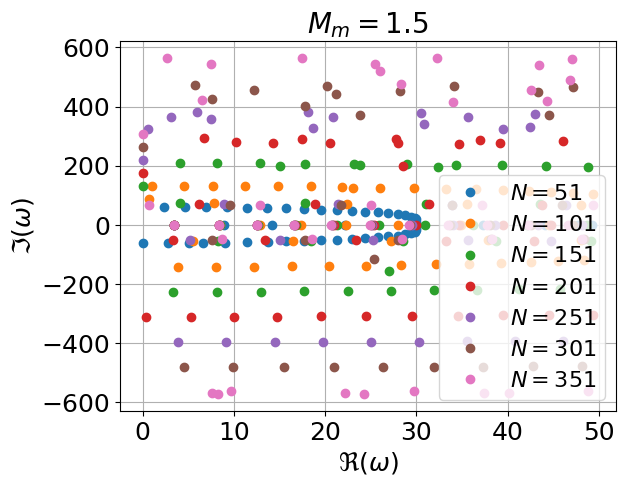

In [5]:
_, ax = plt.subplots()
for exp in experiments:
    exp.plot_eigenvalues(ax=ax)
ax.legend([f"$N=${N}" for N in N_range])
ax.set_title(f"$M_m=${Mm}")
ax.grid()

jere


Text(0.5, 1.0, '$M_m$=1.5')

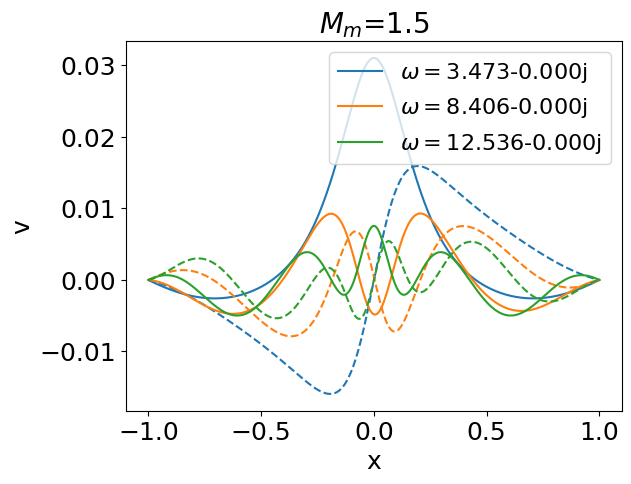

In [17]:
nozzle: Nozzle = copy.deepcopy(experiments[-1])
nozzle.sort_solutions(real_range=[0,25], imag_range=[-1,1])
ax = nozzle.plot_eigenfunctions()
ax.set_title(f"$M_m$={Mm}")

# axins = ax.inset_axes([0.52, 0.5, 0.47, 0.47])
# for i in range(3):
#     axins.plot(x,V[:,i].real,color=f"C{i}")
#     axins.plot(x,V[:,i].imag,"--",color=f"C{i}")
# # sub region of the original image
# x1, x2, y1, y2 = -0.25, 0.25, -0.1, 0.2
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])

# ax.indicate_inset_zoom(axins, edgecolor="black")